# Variational Quantum Eigensolver (VQE)

## What is it?

### My understanding

An algorithm used to find the ground state energy of a given Hamiltonian.

### [Given Definition](https://youtu.be/Z-A6G0WVI9w?feature=shared&t=127)

VQE is a hybrid algorithm, where the quantum part computes the energy, and the classical part optimizes the variational parameter.

### Hamiltonian

A Hamiltonian is just a mathematical description of the total energy of a system

## How can we train it?

In [1]:
!pip install pyscf
!pip install qiskit-aer
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install qiskit-ibm-runtime
!pip install pylatexenc
!pip install qiskit

In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [25]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService.save_account(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='0792027511f6b5b4f9504c5f4ddd35758d6b3c75ed3a89ebec96323522fe514cc4ce1ef92f06c36b5341b8fa8d94f8f9c7efc1033490dd351188b2fb23fc8436',
    set_as_default=True,
    overwrite=True
)

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

### Step 1: Map classical inputs to a quantum problem

In [26]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

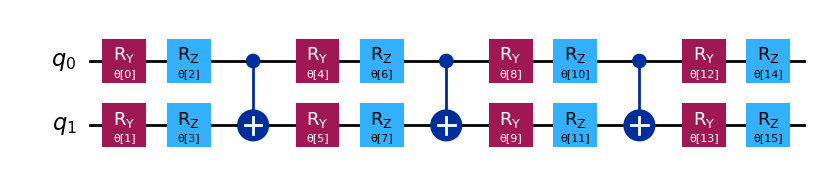

In [27]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [28]:
num_params = ansatz.num_parameters
num_params

16

### Step 2: Optimize problem for quantum execution

In [29]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

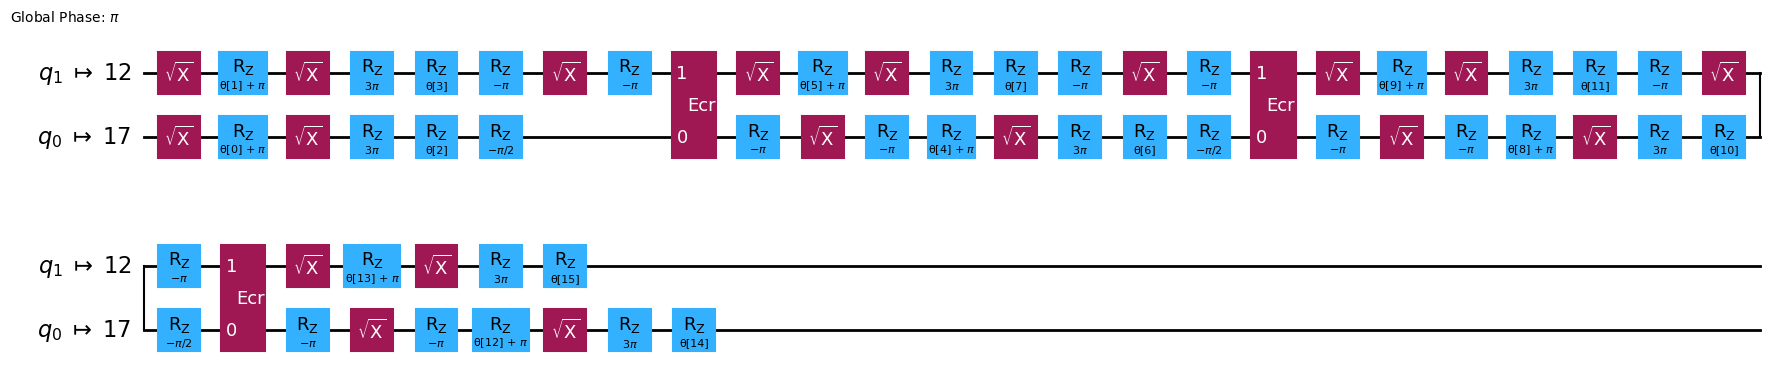

In [30]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

#### ISA observable

In [31]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

Transform the Hamiltonian to make it backend-compatible before running jobs with 
Runtime Estimator V2 Perform the transformation by using the apply_layout method of SparsePauliOp object.

### Step 3: Execute using Qiskit Primitives


In [32]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [33]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [34]:
x0 = 2 * np.pi * np.random.random(num_params)

In [35]:
x0

array([0.86211358, 3.58076246, 4.81075164, 2.99645375, 4.47066147,
       1.9826731 , 1.50450435, 1.45836518, 0.94898655, 5.75652465,
       4.92586691, 1.30990308, 1.72893498, 2.40425487, 0.56255362,
       4.85028075])

In [36]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

/tmp/ipykernel_448/1765566785.py:2: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


Iters. done: 1 [Current cost: -0.13490247268124322]
Iters. done: 2 [Current cost: -0.1804861382425936]
Iters. done: 3 [Current cost: -0.147034635048477]
Iters. done: 4 [Current cost: 0.028368960552784515]
Iters. done: 5 [Current cost: -0.317084061683266]
Iters. done: 6 [Current cost: 0.09908338806374901]
Iters. done: 7 [Current cost: -0.4324032117054883]
Iters. done: 8 [Current cost: -0.5164033779829457]
Iters. done: 9 [Current cost: -0.31827298919294855]
Iters. done: 10 [Current cost: -0.3205427848414523]
Iters. done: 11 [Current cost: -0.4013126802420302]
Iters. done: 12 [Current cost: -0.36717557287768976]
Iters. done: 13 [Current cost: -0.4754779730232778]
Iters. done: 14 [Current cost: -0.3775935151731946]
Iters. done: 15 [Current cost: -0.23985346752502282]
Iters. done: 16 [Current cost: -0.6018602974627015]
Iters. done: 17 [Current cost: -0.4669007682814706]


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6799004481973263
       x: [ 2.016e+00  3.651e+00 ...  2.937e+00  9.882e-01]
    nfev: 176
   maxcv: 0.0

### Step 4: Post-process, return result in classical format

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [ ]:
cost_history_dict["iters"] == res.nfev

True

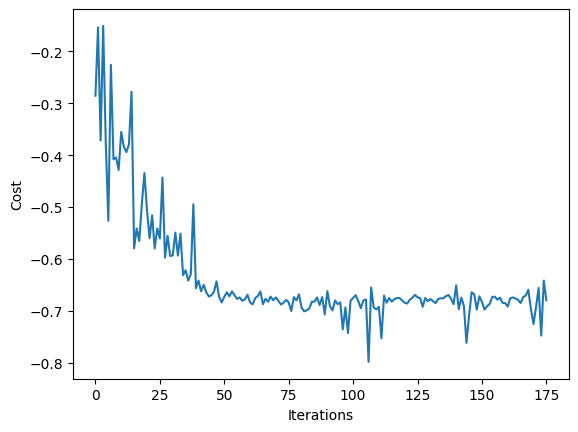

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.25.0'

In [ ]:
import qiskit

qiskit.version.get_version_info()

'1.1.1'

## Use Case

1. Compute the interatomic distance of a molecule

## Citation

[Variational quantum eigensolver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)


[The Variational Quantum Eigensolver — Programming on Quantum Computers — Coding with Qiskit S2E4](https://youtu.be/Z-A6G0WVI9w?feature=shared)

# Quantum Approximate Optimization Algorithm (QAOA):

## What is it

An algorithm designed for solving combinatorial optimization problems.

# Variational Quantum Metrology (VQM):



# Variational Quantum Factoring (VQF):



# Quantum Semidefinite Programming (QSDP):



# Cascaded Variational Quantum Eigensolver (CVQE):



# Neural-Network-Encoded Variational Quantum Algorithms (NNVQA):



# Adaptive Variational Simulation for Open Quantum Systems:



# Quantum Neural Networks (QNNs):



# Quantum Support Vector Machines (QSVMs):

